In [1]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers import Merge

import theano.tensor as T
from keras import backend as K

%matplotlib inline

Using Theano backend.


## Utility functions and global variables

In [2]:
train_path = '../Data/inpainting/train2014/'
val_path = '../Data/inpainting/val2014/'

In [3]:
# Utility function for loading data
def load_data(path, filenames, nb_images=None):
    if nb_images == None:
        nb_images == len(filenames)

    images_list = [mpimg.imread(path + fn).transpose(2, 0, 1) for fn in filenames[0:nb_images]]

    return np.array(images_list)

In [4]:
# Load data

# Train images
# Load valid train images filenames
with open("./Data/train_images_fn.pkl", 'rb') as input:
    train_fn = pickle.load(input)

# Load python dict containing channel-wise means and stds
with open("./Data/train_meanStd_dict.pkl", 'rb') as input:
    train_meanStd_dict = pickle.load(input, encoding='latin1')

x_train = load_data(train_path, train_fn, 10)
y_train = x_train[:, :, 16:48, 16:48].copy()  

# Validation images    
# Load valid validation images filenames
with open("./Data/val_images_fn.pkl", 'rb') as input:
    val_fn = pickle.load(input)

# Load python dict containing channel-wise means and stds
with open("./Data/val_meanStd_dict.pkl", 'rb') as input:
    val_meanStd_dict = pickle.load(input, encoding='latin1')
    
x_val = load_data(val_path, val_fn, 10)
y_val = x_val[:, :, 16:48, 16:48].copy()

'COCO_train2014_000000236818.jpg'

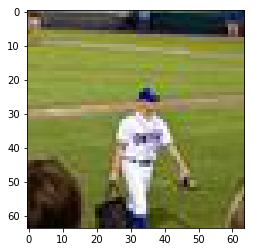

In [7]:
x_train[0].reshape((64,64,3))
plt.imshow(x_train[0].transpose(1, 2, 0))

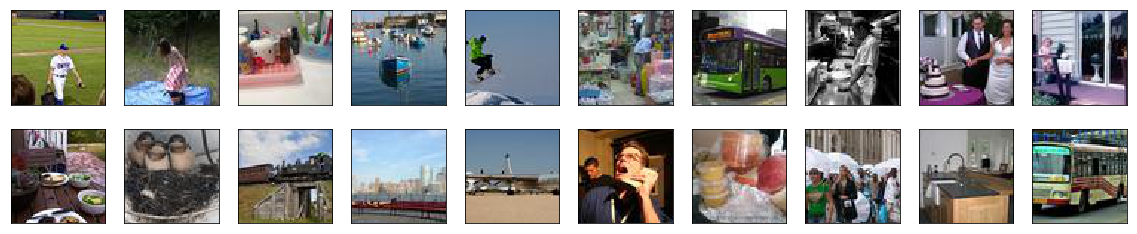

In [6]:
#Show reconstruction results on 10 images from training and validation
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_val[i].transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Visualization

In [12]:
def model_v041():

    # Define model
    autoencoder = models.Sequential()
    # Encoder
    autoencoder.add(Layer(input_shape=(3, 64, 64)))
    autoencoder.add(
        Convolution2D(32, 5, 5, activation='relu', border_mode='same', input_shape=(3, 64, 64), dim_ordering='th'))
    autoencoder.add(BatchNormalization(mode=0, axis=1))
    autoencoder.add(MaxPooling2D((2, 2), border_mode='same', dim_ordering='th'))
    autoencoder.add(
        Convolution2D(32, 4, 4, activation='relu', border_mode='same', input_shape=(64, 32, 32), dim_ordering='th'))
    autoencoder.add(BatchNormalization(mode=0, axis=1))
    autoencoder.add(MaxPooling2D((2, 2), border_mode='same', dim_ordering='th'))
    autoencoder.add(
        Convolution2D(64, 3, 3, activation='relu', border_mode='same', input_shape=(32, 16, 16), dim_ordering='th'))
    autoencoder.add(BatchNormalization(mode=0, axis=1))
    autoencoder.add(MaxPooling2D((2, 2), border_mode='same', dim_ordering='th'))
    # Output : (16, 8, 8)

    # Intermediate layer
    autoencoder.add(Flatten())
    autoencoder.add(Dense(4096))
    autoencoder.add(Reshape((64, 8, 8)))

    # Decoder
    autoencoder.add(
        Convolution2D(64, 3, 3, activation='relu', border_mode='same', input_shape=(16, 8, 8), dim_ordering='th'))
    autoencoder.add(UpSampling2D((2, 2), dim_ordering='th'))
    autoencoder.add(
        Convolution2D(32, 4, 4, activation='relu', border_mode='same', input_shape=(32, 16, 16), dim_ordering='th'))
    autoencoder.add(UpSampling2D((2, 2), dim_ordering='th'))
    autoencoder.add(
        Convolution2D(3, 5, 5, border_mode='same', input_shape=(3, 32, 32), dim_ordering='th'))
    # Output : (3, 32, 32)

    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# load model weights
model = model_v041()
model.load_weights("./Results/Models_v0/convautoencoder_v04.h5")

#Show reconstruction results on 10 images from training and validation
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train[i].transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [77]:
with open("./Results/Models_v0/convautoencoder_v01_trainHistory.pkl", 'rb') as input:
    train_results_v01 = pickle.load(input, encoding='latin1')
    
with open("./Results/Models_v0/convautoencoder_v02_trainHistory.pkl", 'rb') as input:
    train_results_v02 = pickle.load(input, encoding='latin1')
    
with open("./Results/Models_v0/convautoencoder_v03_trainHistory.pkl", 'rb') as input:
    train_results_v03 = pickle.load(input, encoding='latin1')
    
with open("./Results/Models_v0/convautoencoder_v04_trainHistory.pkl", 'rb') as input:
    train_results_v04 = pickle.load(input, encoding='latin1')
    
with open("./Results/Models_v0/convautoencoder_v041_trainHistory.pkl", 'rb') as input:
    train_results_v041 = pickle.load(input, encoding='latin1')

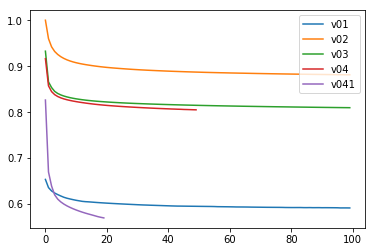

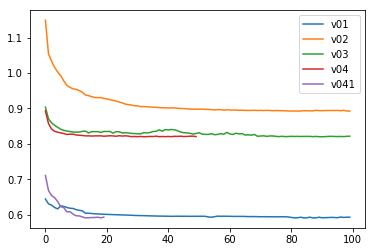

In [81]:
plt.figure()
plt.plot(train_results_v01['loss'], label="v01")
plt.plot(train_results_v02['loss'], label="v02")
plt.plot(train_results_v03['loss'], label="v03")
plt.plot(train_results_v04['loss'], label="v04")
plt.plot(train_results_v041['loss'], label="v041")
plt.legend()

plt.figure()
plt.plot(train_results_v01['val_loss'], label="v01")
plt.plot(train_results_v02['val_loss'], label="v02")
plt.plot(train_results_v03['val_loss'], label="v03")
plt.plot(train_results_v04['val_loss'], label="v04")
plt.plot(train_results_v041['val_loss'], label="v041")
plt.legend()